# <center><h1> Image2Image. Генерация изображений из других избражений

## Использование архитектуры pix2pix </center></h1>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as tt 
import numpy as np
import os
from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from google.colab import files

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!git clone https://github.com/NastyaTataurova/pix2pix_pytorch
os.chdir('pix2pix_pytorch/')

Cloning into 'pix2pix_pytorch'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (262/262), done.
remote: Total 277 (delta 143), reused 20 (delta 8), pack-reused 0
Receiving objects: 100% (277/277), 59.77 KiB | 1.66 MiB/s, done.
Resolving deltas: 100% (143/143), done.


In [ ]:
image_size = 256
# stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transforms = tt.Compose([tt.ToPILImage(),
                         tt.Resize((256, 256)),
                         tt.ToTensor(),
                         # tt.Normalize(*stats)
                         ])

## Discriminator

In [4]:
class discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv0 = nn.Sequential(
        nn.Conv2d(3 * 2, 64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
        nn.LeakyReLU(0.2)
    )
    
    self.conv1 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2)
    )
    
    self.conv2 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2)
    )
    
    self.conv3 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False, padding_mode="reflect"),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2)
    )
    
    self.conv4 = nn.Sequential(
        nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect')
    )
  
  def forward(self, x, y):
      x = torch.cat([x, y], dim=1)
      c0 = self.conv0(x)
      c1 = self.conv1(c0)
      c2 = self.conv2(c1)
      c3 = self.conv3(c2)
      c4 = self.conv4(c3)
      return c4

## Generator

In [5]:
class generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv0 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
        nn.LeakyReLU(0.2)        
    )

    self.conv1 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2)        
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2)        
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2)        
    )

    self.conv456 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2)        
    )

    self.bottleneck = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
        nn.ReLU(0.2)        
    )

    self.dec_conv0 = nn.Sequential(
        nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(0.2),
        nn.Dropout(0.5)        
    )

    self.dec_conv12 = nn.Sequential(
        nn.ConvTranspose2d(512 * 2, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(0.2),
        nn.Dropout(0.5)        
    )

    self.dec_conv3 = nn.Sequential(
        nn.ConvTranspose2d(512 * 2, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(0.2)       
    )

    self.dec_conv4 = nn.Sequential(
        nn.ConvTranspose2d(512 * 2, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(0.2)       
    )

    self.dec_conv5 = nn.Sequential(
        nn.ConvTranspose2d(256 * 2, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(0.2)       
    )

    self.dec_conv6 = nn.Sequential(
        nn.ConvTranspose2d(128 * 2, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(0.2)       
    )

    self.dec_conv7 = nn.Sequential(
        nn.ConvTranspose2d(64 * 2, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Sigmoid() # nn.Tanh()       
    )

  def forward(self, x):
    # encoder
    e0 = self.conv0(x) # 128  
    e1 = self.conv1(e0) # 64  
    e2 = self.conv2(e1) # 32  
    e3 = self.conv3(e2) # 16  
    e4 = self.conv456(e3) # 8  
    e5 = self.conv456(e4) # 4  
    e6 = self.conv456(e5) # 2  

    # bottleneck
    b = self.bottleneck(e6) # 1

    # decoder
    d0 = self.dec_conv0(b) # 2  
    d1 = self.dec_conv12(torch.cat((d0, e6), dim=1)) # 4
    d2 = self.dec_conv12(torch.cat((d1, e5), dim=1)) # 8  
    d3 = self.dec_conv3(torch.cat((d2, e4), dim=1)) # 16  
    d4 = self.dec_conv4(torch.cat((d3, e3), dim=1)) # 32  
    d5 = self.dec_conv5(torch.cat((d4, e2), dim=1)) # 64  
    d6 = self.dec_conv6(torch.cat((d5, e1), dim=1)) # 128  
    d7 = self.dec_conv7(torch.cat((d6, e0), dim=1)) # 256  
    return d7

## Train

In [6]:
def save_model_optimazer(model, optimizer, filename):
    model_opt_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(model_opt_dict, filename)

In [15]:
def load_model_optimazer(filename, model, optimizer, lr, device):
    model_opt_dict = torch.load(filename, map_location=device)
    model.load_state_dict(model_opt_dict['model'])
    optimizer.load_state_dict(model_opt_dict['optimizer'])
    
    for param in optimizer.param_groups:
        param['lr'] = lr

In [8]:
def train(discrim, gener, loader, opt_discrim, opt_gener, loss_l1, loss_bce, num_epoch):
  history = []
  for epoch in tqdm(range(num_epoch)):    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        # Train Discriminator
        y_gener = gener(x)
        discrim_real_image = discrim(x, y)
        discrim_real_image_loss = loss_bce(discrim_real_image, torch.ones_like(discrim_real_image))
        discrim_gener_image = discrim(x, y_gener.detach())
        discrim_gener_image_loss = loss_bce(discrim_gener_image, torch.zeros_like(discrim_gener_image))
        discrim_loss = (discrim_real_image_loss + discrim_gener_image_loss) / 2

        opt_discrim.zero_grad()
        discrim_loss.backward()
        opt_discrim.step()

        # Train Generator
        discrim_gener_image = discrim(x, y_gener)
        G_fake_loss = loss_bce(discrim_gener_image, torch.ones_like(discrim_gener_image))
        L1 = loss_l1(y_gener, y) * lambd
        G_loss = G_fake_loss + L1

        opt_gener.zero_grad()
        G_loss.backward()
        opt_gener.step()

        # clear_output(wait=True)

    history.append((discrim_real_image_loss, discrim_gener_image_loss, discrim_loss))

    print(f'\n{epoch+1}/{num_epoch} epoch: loss={discrim_loss}, generated image loss={discrim_gener_image_loss}')
    plt.subplot(1, 3, 1)
    plt.imshow(x[0].permute(1, 2, 0).cpu().detach().numpy(), vmin=0, vmax=255)
    plt.title('Real')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(y[0].permute(1, 2, 0).cpu().detach().numpy(), vmin=0, vmax=255)
    plt.title('Target')
    plt.axis('off')

    image_fake = np.asarray(y_gener[0].permute(1, 2, 0).cpu().detach().numpy(), dtype=np.float32)
    plt.subplot(1, 3, 3)
    plt.imshow(image_fake, vmin=0, vmax=255)
    plt.title('Fake')
    plt.axis('off')

  return history

## Dataset 1 -- Maps

In [ ]:
class GetDatasetMaps(Dataset):
    def __init__(self, file_paths, transform):
        self.file_paths = file_paths
        self.files_names = os.listdir(file_paths)
        self.transform = transform

    def __len__(self):
        return len(self.files_names)

    def __getitem__(self, idx):
        file_name = self.files_names[idx]
        file_path = os.path.join(self.file_paths, file_name)
        image = Image.open(file_path)
        image = np.array(image)

        input_image = image[:, :600, :]
        target_image = image[:, 600:, :]

        input_image = self.transform(input_image)
        target_image = self.transform(target_image)

        return input_image, target_image

In [ ]:
# loading maps dataset
!bash ./bin/get_maps_datasets.sh

In [ ]:
# loading the weights of a model trained on a dataset with maps
%%time
!pip install -q -U --no-cache-dir gdown --pre
!gdown --id 1FNSg9qF8LMaI5GujFl4vyfYnf0j8JVSW
!gdown --id 17vBZy44-irz4OAfnJ00q-nujyeYjTBrW

In [ ]:
# path to images
train_path_maps = './pix2pix_pytorch/datasets/maps/train'
val_path_maps = './pix2pix_pytorch/datasets/maps/val'

# creating a train dataloader
train_dataset_maps = GetDatasetMaps(file_paths=train_path_maps, transform=transforms)
train_loader_maps = DataLoader(train_dataset_maps, batch_size=1)

# creating a val dataloader
val_dataset_maps = GetDatasetMaps(file_paths=val_path_maps, transform=transforms)
val_loader_maps = DataLoader(val_dataset_maps, batch_size=5)

### Train model 1 (Maps)

In [ ]:
lr = 2e-4
lambd = 100

In [ ]:
discrim_maps = discriminator().to(device)
optimizer_discrim_maps = torch.optim.Adam(discrim_maps.parameters(), lr=lr, betas=(0.5, 0.9))
loss_bce_maps = nn.BCEWithLogitsLoss()

gener_maps = generator().to(device)
optimizer_gener_maps = torch.optim.Adam(gener_maps.parameters(), lr=lr, betas=(0.5, 0.9))
loss_l1_maps = nn.L1Loss()

In [ ]:
print('Load model and optimizer?')
if input() == 'y': # 'y' - yes, else - no
  # loading the weights of the trained model
  load_model_optimazer('discrim_maps.pth', discrim_maps, optimizer_discrim_maps, lr, device)
  load_model_optimazer('gener_maps.pth', gener_maps, optimizer_gener_maps, lr, device)
else:
  # train model
  num_epoch = 100
  train(discrim_maps, gener_maps, train_loader_maps, optimizer_discrim_maps, optimizer_gener_maps, loss_l1_maps, loss_bce_maps, num_epoch)

### Results (Maps)

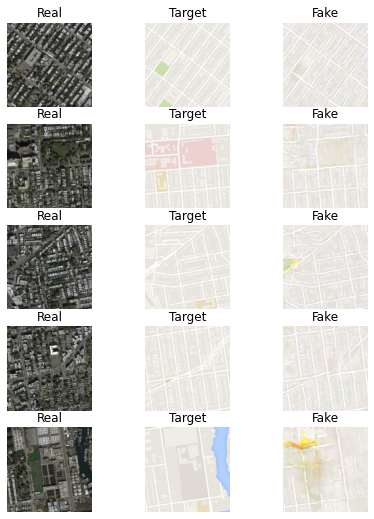

In [ ]:
X_val = next(iter(val_loader_maps))
y_val = gener_maps(X_val[0].to(device))

plt.figure(figsize=(7, 9))  
for i in range(5):
  plt.subplot(5, 3, 3*i+1)
  plt.imshow(X_val[0][i].permute(1, 2, 0), vmin=0, vmax=255)
  plt.title('Real')
  plt.axis('off')

  plt.subplot(5, 3, 3*i+2)
  plt.imshow(X_val[1][i].permute(1, 2, 0), vmin=0, vmax=255)
  plt.title('Target')
  plt.axis('off')

  gener_image = np.asarray(y_val[i].permute(1, 2, 0).cpu().detach().numpy(), dtype=np.float32)
  plt.subplot(5, 3, 3*i+3)
  plt.imshow(gener_image, vmin=0, vmax=255)
  plt.title('Fake')
  plt.axis('off')

### Saving weights (Maps)

In [ ]:
save_model_optimazer(discrim_maps, optimizer_discrim_maps, 'discrim_maps.pth')
save_model_optimazer(gener_maps, optimizer_gener_maps, 'gener_maps.pth')

### Upload your image (Maps)

In [ ]:
# uploading an image
file = files.upload()

# image generation
file_path = os.path.join('./pix2pix_pytorch/', list(file.keys())[0])
image = Image.open(file_path)
image = transforms(np.array(image))

gener_image = gener_maps(image.unsqueeze(0).to(device))[0]
gener_image = np.asarray(gener_image.permute(1, 2, 0).cpu().detach().numpy(), dtype=np.float32)

# result
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0), vmin=0, vmax=255)
plt.title('Real')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gener_image, vmin=0, vmax=255)
plt.title('Fake')
plt.axis('off')

## Dataset 2 -- Flowers

In [9]:
class GetDatasetFlowers(Dataset):
    def __init__(self, file_paths_jpg, file_paths_trimaps, transform):
        self.file_paths_jpg = file_paths_jpg
        self.file_paths_trimaps = file_paths_trimaps

        self.files_names_jpg = os.listdir(file_paths_jpg)
        self.files_names_trimaps = os.listdir(file_paths_trimaps)

        self.transform = transform

    def __len__(self):
        return len(self.file_paths_jpg)

    def __getitem__(self, idx):
        file_name_trimaps = self.files_names_trimaps[idx]
        file_name_jpg = file_name_trimaps[:11] + 'jpg'

        file_path_jpg = os.path.join(self.file_paths_jpg, file_name_jpg)
        image_target = Image.open(file_path_jpg)
        image_target = np.array(image_target)
        
        file_path_trimaps = os.path.join(self.file_paths_trimaps, file_name_trimaps)
        image_trimaps = cv2.imread(file_path_trimaps)
        image_trimaps = np.array(image_trimaps)

        image_target = self.transform(image_target)
        image_trimaps = self.transform(image_trimaps)

        return image_trimaps, image_target

In [ ]:
# loading flowers dataset
!bash ./bin/get_flowers_datasets.sh

In [11]:
# loading the weights of a model trained on a dataset flowers
%%time
!pip install -q -U --no-cache-dir gdown --pre
!gdown --id 1h4fLxg9e4sYTdi_eniiP5CTHPKtOZM1O
!gdown --id 1h5Hk2h9aik16ZFvMaRWNkO9shQaqmiMU

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Downloading...
From: https://drive.google.com/uc?id=1h4fLxg9e4sYTdi_eniiP5CTHPKtOZM1O
To: /content/pix2pix_pytorch/discrim_flowers.pth
33.2MB [00:00, 66.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1h5Hk2h9aik16ZFvMaRWNkO9shQaqmiMU
To: /content/pix2pix_pytorch/gener_flowers.pth
452MB [00:04, 96.4MB/s]
CPU times: user 115 ms, sys: 46.7 ms, total: 162 ms
Wall time: 15.4 s


In [ ]:
# path to train images
train_path_flowers_jpg = './pix2pix_pytorch/datasets/flowers/train/jpg/jpg'
train_path_flowers_trimaps = './pix2pix_pytorch/datasets/flowers/train/trimaps/trimaps'

# path to val images
val_path_flowers_jpg = './pix2pix_pytorch/datasets/flowers/test/jpg/jpg'
val_path_flowers_trimaps = './pix2pix_pytorch/datasets/flowers/test/trimaps/trimaps'

# creating a train dataloader
train_dataset_flowers = GetDatasetFlowers(file_paths_jpg=train_path_flowers_jpg,
                                          file_paths_trimaps=train_path_flowers_trimaps,
                                          transform=transforms)
train_loader_flowers = DataLoader(train_dataset_flowers, batch_size=1)

# creating a val dataloader
val_dataset_flowers = GetDatasetFlowers(file_paths_jpg=val_path_flowers_jpg,
                                        file_paths_trimaps=val_path_flowers_trimaps,
                                        transform=transforms)
val_loader_flowers = DataLoader(val_dataset_flowers, batch_size=5)

### Train model 2 (Flowers)

In [12]:
lr = 2e-4
lambd = 100

In [13]:
discrim_flowers = discriminator().to(device)
optimizer_discrim_flowers = torch.optim.Adam(discrim_flowers.parameters(), lr=lr, betas=(0.5, 0.9))
loss_bce_flowers = nn.BCEWithLogitsLoss()

gener_flowers = generator().to(device)
optimizer_gener_flowers = torch.optim.Adam(gener_flowers.parameters(), lr=lr, betas=(0.5, 0.9))
loss_l1_flowers = nn.L1Loss()

In [14]:
print('Load model and optimizer?')
if input() == 'y': # 'y' - yes, else - no (train)
  # loading the weights of the trained model
  load_model_optimazer('discrim_flowers.pth', discrim_flowers, optimizer_discrim_flowers, lr, device)
  load_model_optimazer('gener_flowers.pth', gener_flowers, optimizer_gener_flowers, lr, device)
else:
  # train model
  num_epoch = 400
  train(discrim_flowers, gener_flowers, train_loader_flowers, optimizer_discrim_flowers, optimizer_gener_flowers, loss_l1_flowers, loss_bce_flowers, num_epoch)

Load model and optimizer?
y


TypeError: ignored

### Results (Flowers)

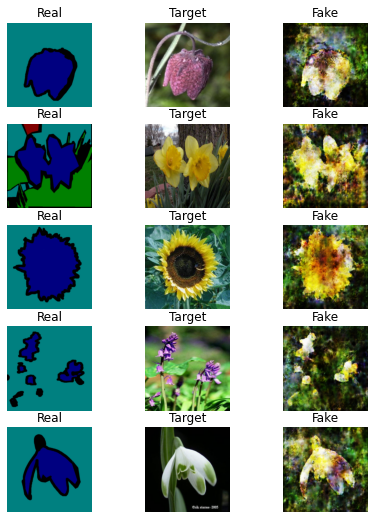

In [ ]:
X_val = next(iter(val_loader_flowers))
y_val = gener_flowers(X_val[0].to(device))

plt.figure(figsize=(7, 9))  
for i in range(5):
  plt.subplot(5, 3, 3*i+1)
  plt.imshow(X_val[0][i].permute(1, 2, 0), vmin=0, vmax=255)
  plt.title('Real')
  plt.axis('off')

  plt.subplot(5, 3, 3*i+2)
  plt.imshow(X_val[1][i].permute(1, 2, 0), vmin=0, vmax=255)
  plt.title('Target')
  plt.axis('off')

  gener_image = np.asarray(y_val[i].permute(1, 2, 0).cpu().detach().numpy(), dtype=np.float32)
  plt.subplot(5, 3, 3*i+3)
  plt.imshow(gener_image, vmin=0, vmax=255)
  plt.title('Fake')
  plt.axis('off')

### Saving weights (Flowers)

In [ ]:
save_model_optimazer(discrim_flowers, optimizer_discrim_flowers, 'discrim_flowers.pth')
save_model_optimazer(gener_flowers, optimizer_gener_flowers, 'gener_flowers.pth')

### Upload your image (Flowers)

(-0.5, 255.5, 255.5, -0.5)

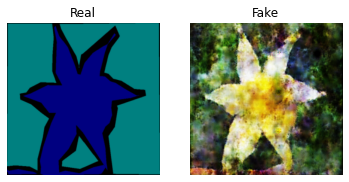

In [ ]:
# uploading an image
file = files.upload()

# image generation
file_path = os.path.join('./pix2pix_pytorch/', list(file.keys())[0])
image = cv2.imread(file_path)
image = transforms(np.array(image))

gener_image = gener_flowers(image.unsqueeze(0).to(device))[0]
gener_image = np.asarray(gener_image.permute(1, 2, 0).cpu().detach().numpy(), dtype=np.float32)

# result
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0), vmin=0, vmax=255)
plt.title('Real')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gener_image, vmin=0, vmax=255)
plt.title('Fake')
plt.axis('off')